In [27]:
import pandas as pd
import numpy as np
import gudhi as gd
import statsmodels.api as sm 
import gudhi.representations
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.representations.vector_methods import Landscape
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from numpy import linalg as LA
import datetime as dt
import skfda.misc.metrics as mt
import skfda
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import spearmanr,kurtosis,norm
import random
import persim.persistent_entropy as pe
import statsmodels.tsa.api as smt


nasdaq = 'NASDAQ1971+.csv'
sp500 = 'S&P500.csv'
sp100Global = 'S&PGLOBAL100.csv'
vix = 'VIX.csv'

class IndexTDA():
    
    '''
    filename:= [string] Filename of the csv we want to perform the analysis
    startDate:= [(year,month,day)]The starting date from which we want to perform our analysis
    d:= [int]Taken's Embedding dimension parameter
    tau:= [int] Time delay parameter
    v := [int] Number of days to take into consideration for each pointcloud
    d1_d1 := [Array[(int,int)] Array of tuples with rolling windows dimensions
    '''
    def __init__(self,filename,startDate=None,endDate=None,d=2,tau =1,skip=1,v=21,d1_d2 = [(126,63),(126, 42),(126, 21),(63, 21)], p = 1, kinConsideration = 1000, res = 1000):
        
        self.filename = filename
        self.data = pd.read_csv(self.filename)
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        self.data.set_index('Date', inplace = True)
        self.data['Close'] = [float(c) for c in self.data.Close]
        self.data['LogRet'] = np.log(self.data.Close) - np.log(self.data.Close.shift(1))
        self.d1_d2 = d1_d2
        aux = self.data.index[1]
        firstday = (aux.year,aux.month,aux.day)
        self.startDate = firstday if (not startDate) else startDate
        self.startIndex = self.getIndex(self.startDate)
        aux = self.data.index[-1]
        lastday = (aux.year,aux.month,aux.day)
        self.endDate = lastday if (not endDate) else endDate
        self.finalIndex = self.getIndex(self.endDate)
        self.v = v
        self.numberOfPoints = (v - (d - 1)*tau)
        TD = TimeDelayEmbedding(dim = d,delay = tau, skip= skip)
        #ROLLING WINDOW STRATEGY POINT CLOUDS
        #====================================
        self.numberOfAnalyses = len(self.d1_d2)
        self.finalIndexes = [((self.finalIndex - self.startIndex - pair[0])//pair[1])*pair[1] + pair[0] for pair in d1_d2]
        self.analyses = [[self.data.LogRet[self.startIndex + i*pair[1]:self.startIndex + i*pair[1] + pair[0]] for i in range(0,(self.finalIndex - self.startIndex - pair[0])//pair[1])] for pair in d1_d2]
        self.TDEmbAnalyses = [[TD.__call__(window) for window in analysis] for analysis in self.analyses]
        self.rollingwindowLogRets = [[[window[i:self.v+i] 
                    for i in range(0, len(window) - (self.v + 1))]
                        for window in analysis]
                            for analysis in self.analyses] 
        self.rollingWindowPointClouds = [[[window[i:self.numberOfPoints+i] 
                    for i in range(0, len(window) - (self.numberOfPoints + 1))]
                        for window in analysis]
                            for analysis in self.TDEmbAnalyses] 
        #=======================================
        #NON ROLLING WINDOW STRATEGY
        #===========================
        embeddedData = TD.__call__(self.data.LogRet[self.startIndex:self.finalIndex +1])
        self.pointClouds = [embeddedData[i:self.numberOfPoints+i] for i in range(0, len(embeddedData) - (self.numberOfPoints + 1))]
        #===========================
        self.LpTS = pd.DataFrame(data=[])
        self.RWLpTS = None
        self.STDTS = pd.DataFrame(data=[])
        self.RWSTDTS = None
        self.ACFTS = pd.DataFrame(data=[])
        self.RWACFTS = None
        self.KURTS = pd.DataFrame(data=[])
        self.RWKURTS = None
        self.PETS = pd.DataFrame(data=[])
        self.VaRTS = pd.DataFrame(data=[])
        self.ExpShtfllTS = pd.DataFrame(data=[])
            
    def getIndex(self, dateTuple):
        return self.data.index.get_loc(dt.datetime(dateTuple[0],dateTuple[1],dateTuple[2]))
    
    def getClosePrice(self):
        return pd.Series(data = self.data.Close[self.startIndex+self.v:self.finalIndex])
    
    def getLogRet(self):
        return pd.Series(data = self.data.LogRet[self.startIndex+self.v:self.finalIndex])
    
    def getSTDTimeSeries(self):
        if self.STDTS.empty:
             self.STDTS = pd.DataFrame(data = [(self.data.LogRet[i:self.v+i].values).std() for i in range(self.startIndex,self.finalIndex - self.v)], index = self.data.index[self.startIndex:self.finalIndex - self.v])
        return self.STDTS
       
    def getACFTimeSeries(self):
        if self.ACFTS.empty:
            self.ACFTS = pd.DataFrame(data = [smt.acf(self.data.LogRet[i:self.v+i].values)[1] for i in range(self.startIndex,self.finalIndex - self.v)], index = self.data.index[self.startIndex:self.finalIndex - self.v])
        return self.ACFTS
    
    def getKurtosisTimeSeries(self):
        if self.KURTS.empty:
            self.KURTS = pd.DataFrame(data = [kurtosis(self.data.LogRet[i:self.v+i].values) for i in range(self.startIndex,self.finalIndex - self.v)], index = self.data.index[self.startIndex:self.finalIndex - self.v])
        return self.KURTS
    
    def getlandscapesLpNormTimeSeries(self):
        if self.LpTS.empty:
            self.landscapesLpNormTimeSeries()
        return self.LpTS
    
    def getpersistenceEntropyTimeSeries(self):
        if self.PETS.empty:
            self.persistenceEntropyTimeSeries()
        return self.PETS
    
    def getVaRTimeSeries(self):
        if self.VaRTS.empty:
            self.VaRTS = self.VaRTimeSeries()
        return self.VaRTS
    
    def getESTimeSeries(self):
        if self.ExpShtfllTS.empty:
            self.ExpShtfllTS = self.ESTimeSeries()
        return self.ExpShtfllTS
        
    def getrollingWindowLandscapesLpNormTimeSeries(self):
        if self.RWLpTS is None:
            self.rollingWindowPersistenceLandscapesLpNormTimeSeries()
        return self.RWLpTS
        
    def getrollingWindowSTDTimeSeries(self):
        if self.RWSTDTS is None:
            self.RWSTDTS = [[[lrets.values.std() for lrets in window] for window in analysis] for analysis in self.rollingwindowLogRets]
        return self.RWSTDTS

    def getrollingWindowACFTimeSeries(self):
        if self.RWACFTS is None:
            self.RWACFTS = [[[smt.acf(lrets.values)[1] for lrets in window] for window in analysis] for analysis in self.rollingwindowLogRets]
        return self.RWACFTS
    
    def getrollingWindowKurtosisTimeSeries(self):
        if self.RWKURTS is None:
            self.RWKURTS = [[[kurtosis(lrets.values) for lrets in window] for window in analysis] for analysis in self.rollingwindowLogRets]
        return self.RWKURTS
    
    def rollingWindowPersistenceLandscapesLpNormTimeSeries(self,p=1,kinConsideration = 5, res = 1000):
        rollingWindowPLLpN = []
        for analysis in self.rollingWindowPointClouds:
            wsPLLpN = []
            for window in analysis:
                wPLLpN = []
                for pc in window:
                    LS = gd.representations.Landscape(resolution=res, num_landscapes = kinConsideration)
                    try:
                        diagram = ripser(pc)['dgms']
                        landscape = LS.fit_transform([diagram[1]])[0]
                        sample_range = LS.sample_range
                        if p == 1:
                            wPLLpN.append(self.L1(landscape,sample_range,kinConsideration,res))
                        else:
                            wPLLpN.append(self.Lp(landscape,p,sample_range,kinConsideration,res))
                    except:
                        wPLLpN.append(0)
                wsPLLpN.append(np.array(wPLLpN))
            rollingWindowPLLpN.append(np.array(wsPLLpN))
        self.RWLpTS = rollingWindowPLLpN
        return self.RWLpTS
   
    '''
    Computes persistence landscapes lp norm time series
    p: [int] Lp norm value
    kinconsideration:[int] Number of landscapes into consideration
    res: [int] Number of persistence landscape function points into consideration 
    '''
    def landscapesLpNormTimeSeries(self,  p = 1, kinConsideration = 5, res = 1000):  
        if p < 1:
            return 'p must be greater or equal than 1'
        LS = gd.representations.Landscape(resolution=res, num_landscapes = kinConsideration)
        Lp = []
        for pc in self.pointClouds:
            try:
                diagram = ripser(pc)['dgms']
                landscape = LS.fit_transform([diagram[1]])[0]
                sample_range = LS.sample_range
                if p == 1:
                    Lp.append(self.L1(landscape,sample_range,kinConsideration,res))
                else:
                    Lp.append(self.Lp(landscape,p,sample_range,kinConsideration,res))
            except:
                Lp.append(0)
        self.LpTS = pd.DataFrame(data = np.array(Lp),index = self.data.index[self.startIndex:self.finalIndex - self.v])
        return self.LpTS
    
    def persistenceEntropyTimeSeries(self,d=0):
        PETS = []
        for pc in self.pointClouds:
            try:
                diagram = ripser(pc)['dgms']
                if d == 0:
                    diagram = diagram[d][:-1]
                else:
                    diagram = diagram[d]
                PETS.append(pe.persistent_entropy(diagram, normalize=True))
            except:
                PETS.append(0)
        self.PETS = pd.DataFrame(data = np.array(PETS),index = self.data.index[self.startIndex:self.finalIndex - self.v])
        return self.PETS   
    
     
    def VaRTimeSeries(self, bssize = 100):
        bs_vars = np.array([[np.percentile(np.random.choice(self.data.LogRet[i:self.v+i],len(self.data.LogRet[i:self.v+i])), 5, interpolation="lower") for j in range(0,bssize)] for i in range(self.startIndex,self.finalIndex - self.v)])
        VaR = pd.DataFrame(data = np.array([np.mean(s_var) for s_var in bs_vars]), index = self.data.index[self.startIndex:self.finalIndex - self.v])
        return VaR
    
    def ESTimeSeries(self, bssize = 100):
        bs_ret = np.array([[np.random.choice(self.data.LogRet[i:self.v+i],len(self.data.LogRet[i:self.v+i])) for j in range(0,bssize)] for i in range(self.startIndex,self.finalIndex - self.v)])
        bs_vars = np.array([np.percentile(bs, 5, interpolation = 'lower') for bs in bs_ret])
        worst_ret = np.array([bs_ret[i][bs_ret[i] <= bs_vars[i]] for i in range(len(bs_ret))])
        ES = np.array([np.mean(wr) for wr in worst_ret])
        return pd.DataFrame(data = ES, index = self.data.index[self.startIndex:self.finalIndex - self.v])
    
    def integrateSplines(self, f, x_sample):
        
        t = [0,1]
        c = 1
        s = 0
        
        resolution = len(x_sample)
        
        for i in range(2,resolution):
            if c == 1 and f[i] < f[t[1]]:
                c = -1
                s += (x_sample[t[1]] - x_sample[t[0]])*(f[t[1]] + f[t[0]])
                t = [t[1],i]
            elif c == -1 and f[i] >= f[t[1]]:
                c = 1*(f[i] > f[t[1]])
                s += (x_sample[t[1]] - x_sample[t[0]])*(f[t[1]] + f[t[0]])
                t = [t[1],i]
            elif c == 0 and f[i] > f[t[1]]:
                c = 1
                t = [t[1],i]
            else:
                t[1] = i
                
        return  0.5*(s + (x_sample[t[1]] - x_sample[t[0]])*(f[t[1]] + f[t[0]]))
        
    
    def L1(self,landscape,sample_range,kinConsideration = 5, resolution = 1000):
        return sum([self.integrateSplines(landscape[resolution*i:resolution*(i+1)], np.linspace(sample_range[0],sample_range[1],resolution)) for i in range(0,kinConsideration)])
    
    def Lp(self, landscape, p, sample_range, kinConsideration = 5, resolution = 1000):
        return sum([mt.lp_norm(skfda.FDataGrid([landscape[resolution*i:resolution*(i+1)]],np.linspace(sample_range[0],sample_range[1],1000)),p) for i in range(0,kinConsideration)])
    
        
    def plotIndex(self, col ='b'):
        fig = plt.figure(figsize=(5,2.5))
        plt.plot(self.getClosePrice(),color = col,linewidth=0.5)
        fig.suptitle(self.filename[:-4], fontsize=15)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Index Value', fontsize=10)
        plt.grid(True)
        fig.savefig(self.filename[:-4]+'.jpg')
        
    
    def plotlogRet(self,col='b'):
        fig = plt.figure(figsize=(5,2.5))
        plt.plot(self.getLogRet(),color = col, linewidth=0.5)
        fig.suptitle(self.filename[:-4], fontsize=15)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Logaritmic Returns', fontsize=10)
        plt.grid(True)
        fig.savefig(self.filename[:-4]+'.jpg')
    
    def plotlandscapesLpNormTimeSeries(self, p = 1, col = 'r'):
        fig = plt.figure(figsize=(5,2.5))
        fig.suptitle(self.filename[:-4] + ' L' + str(p) + ' Norm', fontsize=15)
        n = self.landscapesLpNormTimeSeries()
        plt.plot(n,label = 'L'+ str(p), linewidth=0.5, color = col)
        plt.grid(True)
        plt.legend()
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Norm Value', fontsize=10)
        
    def plotSTDTimeSeries(self, col='y'):
        fig = plt.figure(figsize=(5,2.5))
        fig.suptitle(self.filename[:-4] + ' STDs', fontsize=15)
        plt.plot(self.getSTDTimeSeries(),label = 'STDs', linewidth=0.5, color = col)
        plt.grid(True)
        plt.legend()
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('STDs Value', fontsize=10)
                               
    def plotACFTimeSeries(self,col='g'):
        fig = plt.figure(figsize=(5,2.5))
        fig.suptitle(self.filename[:-4] + ' ACF', fontsize=15)
        plt.plot(self.getACFTimeSeries(),label = 'ACF', linewidth=0.5, color = col)
        plt.grid(True)
        plt.legend()
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('ACF Value', fontsize=10)
    
    def plotKurtosisTimeSeries(self,col='g'):
        fig = plt.figure(figsize=(5,2.5))
        fig.suptitle(self.filename[:-4] + ' Kurt', fontsize=15)
        plt.plot(self.getKurtosisTimeSeries(),label = 'Kurt', linewidth=0.5, color = col)
        plt.grid(True)
        plt.legend()
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Kurt Value', fontsize=10)
        
    def plotpersistenceEntropyTimeSeries(self,col='r'):
        fig = plt.figure(figsize=(5,2.5))
        fig.suptitle(self.filename[:-4] + ' Persitence Entropy', fontsize=15)
        plt.plot(self.getpersistenceEntropyTimeSeries(),label = 'PEntr', linewidth=0.5, color = col)
        plt.grid(True)
        plt.legend()
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('PEntr Value', fontsize=10)
    
    def plotVaRTimeSeries(self, col='y'):
        fig = plt.figure(figsize=(5,2.5))
        fig.suptitle(self.filename[:-4] + ' VaR Bootstrap', fontsize=15)
        plt.plot(self.getVaRTimeSeries(),label = 'VaR', linewidth=0.5, color = col)
        plt.grid(True)
        plt.legend()
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('VaR Value', fontsize=10)
    
    def plotESTimeSeries(self, col='o'):
        fig = plt.figure(figsize=(5,2.5))
        fig.suptitle(self.filename[:-4] + ' ES Bootstrap', fontsize=15)
        plt.plot(self.getESTimeSeries(),label = 'ES', linewidth=0.5, color = col)
        plt.grid(True)
        plt.legend()
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('VaR Value', fontsize=10)
    
                                    

# Empirical Results

In [18]:
SP500 = IndexTDA(sp500,startDate=(2000,1,3),d=2,v=21)

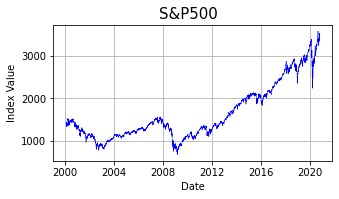

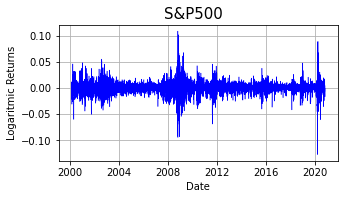

In [19]:
SP500.plotIndex()
SP500.plotlogRet()

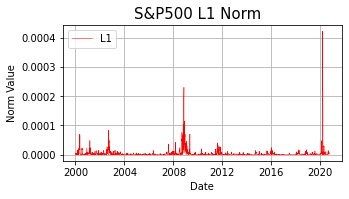

In [20]:
SP500.plotlandscapesLpNormTimeSeries()

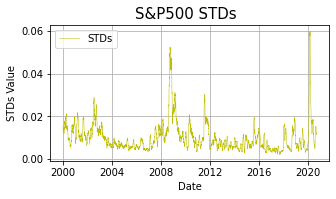

In [21]:
SP500.plotSTDTimeSeries()

In [22]:
coef, p = spearmanr(SP500.getSTDTimeSeries().values, SP500.getlandscapesLpNormTimeSeries().values)
print('SPEARMAN CORRELATION: '+ str(coef),'\nP-VALUE ' + str(p))

SPEARMAN CORRELATION: 0.4736222800576446 
P-VALUE 8.68082722370775e-290


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


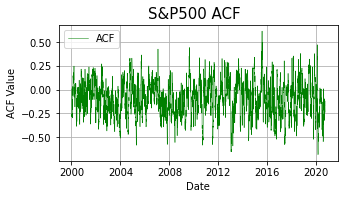

In [23]:
SP500.plotACFTimeSeries()

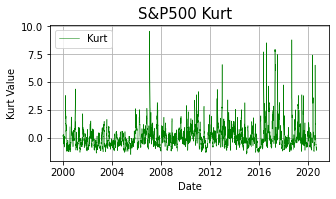

In [24]:
SP500.plotKurtosisTimeSeries()

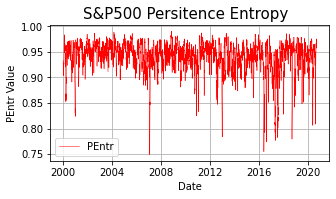

In [25]:
SP500.plotpersistenceEntropyTimeSeries()

<ipython-input-26-b17f2490f975>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  TDA_STD_RHO = np.array(TDA_STD_RHO)


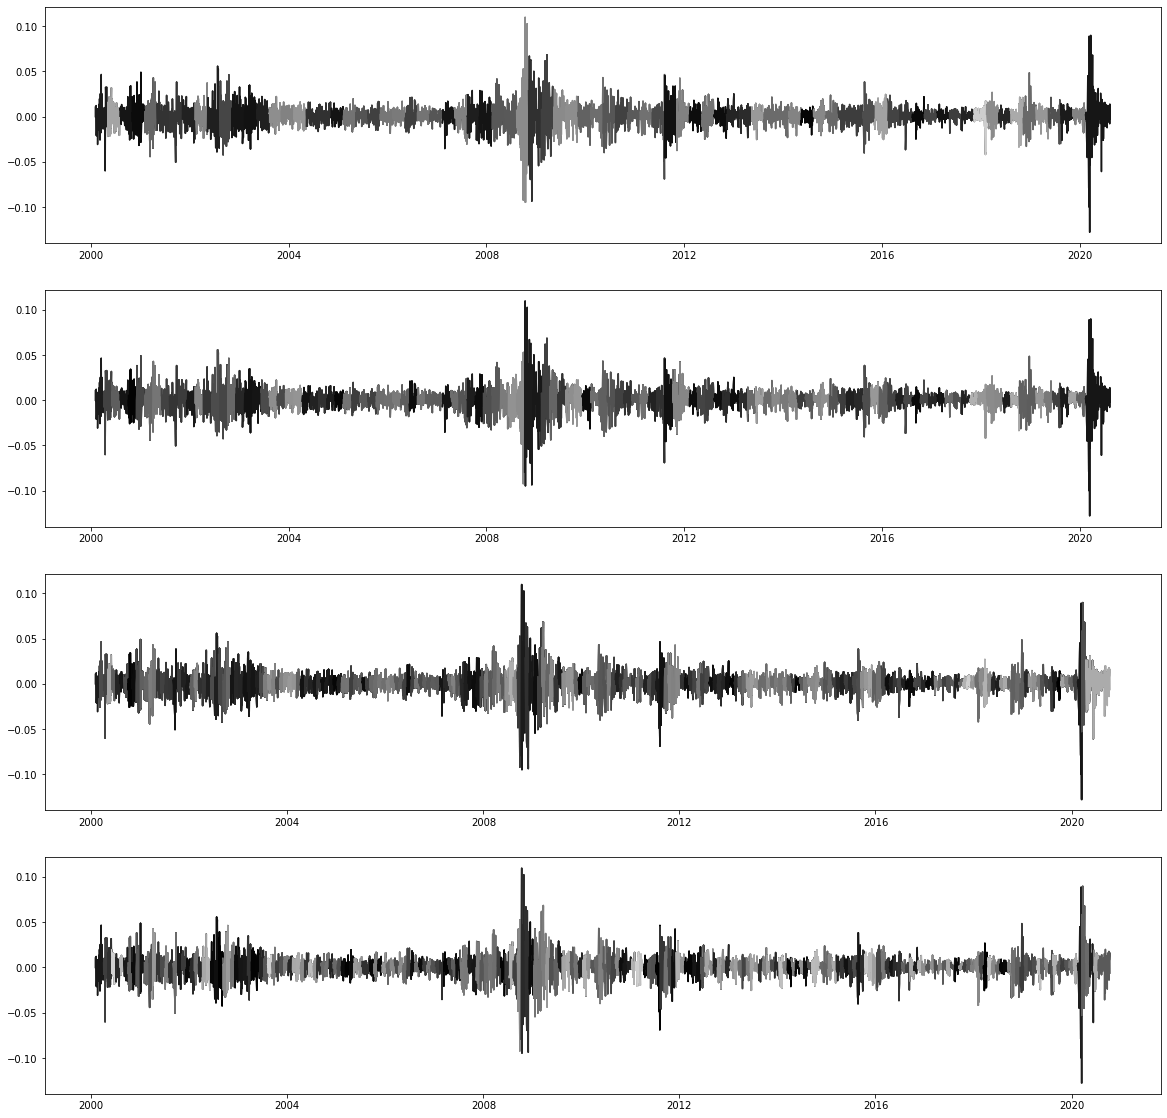

In [26]:
#Rolling window method strategy to visualize in which point clouds the std has a higher or lower spearman coefficient
TDA = SP500.getrollingWindowLandscapesLpNormTimeSeries()
STD = SP500.getrollingWindowSTDTimeSeries()
logpr= SP500.getLogRet()

fig, axs = plt.subplots(SP500.numberOfAnalyses,figsize=(5*SP500.numberOfAnalyses,5*SP500.numberOfAnalyses))

TDA_STD_RHO = []


for analysisTDA, analysisSTD in zip(TDA,STD):
    
    TDA_STD_WINDOW_RHO = []
    
    for windowTDA, windowSTD in zip(analysisTDA,analysisSTD):
        aux = zip(range(len(windowSTD)),abs(np.array(windowSTD)))
        sort =sorted(aux, key= lambda x: x[1])
        aux2 = [windowTDA[x[0]] for x in sort]
        aux3 = [x[1] for x in sort]
        coef, p = spearmanr(aux3, aux2)
        TDA_STD_WINDOW_RHO.append(coef)
    
    TDA_STD_RHO.append(TDA_STD_WINDOW_RHO)
    
TDA_STD_RHO = np.array(TDA_STD_RHO)


for i in range(SP500.numberOfAnalyses):
    for j in range(len(TDA_STD_RHO[i])):
        axs[i].plot(logpr[SP500.d1_d2[i][1]*j: SP500.d1_d2[i][1]*j + SP500.d1_d2[i][0]], c=(abs(TDA_STD_RHO[i][j]),abs(TDA_STD_RHO[i][j]),abs(TDA_STD_RHO[i][j])))
    